# NLP project work
Summary: Casting text classification to Graph Classification for Sentiment Analysis of Tweets
Members:

-Dell'Olio Domenico
-Delvecchio Giovanni Pio
-Disabato Raffaele

The project was developed in order to evaluate the effectiveness of Graph Neural network on a sentiment analysis task proposed in the challenge:
https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification?resource=download

We decided to implement and test various architectures, including commonly employed transformer-based architectures, in order to compare their performances.
These architectures were either already present at the state of the art or were obtained as a result of experiments.


## This notebook contains the following:
- Dataset analysis, preprocessing and splitting
- Dataset conversion to graph structure

In [2]:
# imports for dataset analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# imports for dataset splitting
import re
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# imports for dataset-to-graphs conversion
import torch
from torch import save, load
from torch_geometric.loader import DataLoader
from torch_geometric.utils import scatter

import utils
from utils import Dataset_from_sentences
from utils import delete_processed_files

2023-09-14 21:22:19 INFO: Downloading default packages for language: en (English)...
2023-09-14 21:22:22 INFO: File exists: C:\Users\giova\stanza_resources\en\default.zip.
2023-09-14 21:22:26 INFO: Finished downloading models and saved to C:\Users\giova\stanza_resources.
2023-09-14 21:22:26 INFO: Loading these models for language: en (English):
| Processor | Package                 |
---------------------------------------
| tokenize  | ../Tweeban...kenizer.pt |
| pos       | ../Tweeban..._tagger.pt |
| lemma     | ../Tweeban...matizer.pt |
| depparse  | ../Tweeban..._parser.pt |
| ner       | ontonotes               |

2023-09-14 21:22:26 INFO: Use device: gpu
2023-09-14 21:22:26 INFO: Loading: tokenize
2023-09-14 21:22:26 INFO: Loading: pos


[['tokenize', 'combined'], ['pos', 'combined'], ['lemma', 'combined'], ['depparse', 'combined'], ['ner', 'ontonotes']]


2023-09-14 21:22:28 INFO: Loading: lemma
2023-09-14 21:22:28 INFO: Loading: depparse
2023-09-14 21:22:30 INFO: Loading: ner
2023-09-14 21:22:32 INFO: Done loading processors!


saving directory missing
Utils have been correctly loaded


## Dataset Analysis, Preprocessing and Splitting

First, we open the dataset <code>.csv</code> file to look at its composition and attributes

In [3]:
df=pd.read_csv("content/Corona_NLP_train.csv", encoding='latin1')
df.head

<bound method NDFrame.head of        UserName  ScreenName                      Location     TweetAt  \
0          3799       48751                        London  16-03-2020   
1          3800       48752                            UK  16-03-2020   
2          3801       48753                     Vagabonds  16-03-2020   
3          3802       48754                           NaN  16-03-2020   
4          3803       48755                           NaN  16-03-2020   
...         ...         ...                           ...         ...   
41152     44951       89903  Wellington City, New Zealand  14-04-2020   
41153     44952       89904                           NaN  14-04-2020   
41154     44953       89905                           NaN  14-04-2020   
41155     44954       89906                           NaN  14-04-2020   
41156     44955       89907  i love you so much || he/him  14-04-2020   

                                           OriginalTweet           Sentiment  
0      @MeNyrb

The dataset contains six attributes:
- UserName and ScreenName which represents the tweet poster. They have been obscured with unique ID for privacy reason;
- Location from where the tweet is posted;
- Date of the post;
- Content of the tweet;
- Ground truth.
Quite obviously, only the last two columns are interesting for our task.

We then proceed to remove useless columns.

In [8]:
# dropping columns
# we do not drop tweets with NaN values on location
df.drop(columns=['UserName','ScreenName','Location','TweetAt'], inplace=True)
df

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...
41152,Airline pilots offering to stock supermarket s...,Neutral
41153,Response to complaint not provided citing COVI...,Extremely Negative
41154,You know itÂs getting tough when @KameronWild...,Positive
41155,Is it wrong that the smell of hand sanitizer i...,Neutral


We then do a quick rundown of the distribution of the class labels and plot an histogram

In [9]:
sentiments=df.Sentiment.value_counts()
sentiments

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

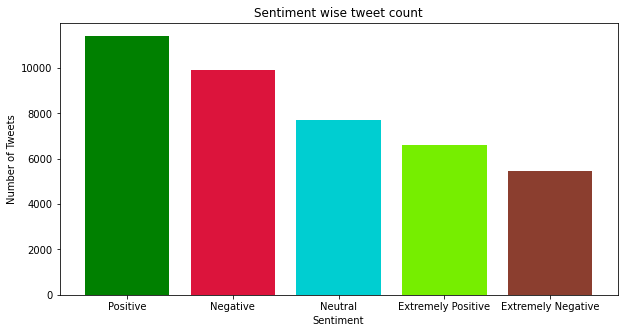

In [10]:
plt.subplots(figsize=(10,5))
plt.bar(sentiments.index,sentiments.values, color=['green','#DC143C','#00CED1','#76EE00','#8B3E2F'])
plt.title("Sentiment wise tweet count")
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

As we can see, the most common classes are the "Negative" and "Positive" ones, with the latter being more of the former. The same pattern can be seen
in their "extreme" counterparts.

We also analyze the distirbution of the lenghts of the tweets by plotting an histogram and a distribution graph.
The lenght is computed by trivially splitting strings at whitespace.

C:\Users\giova\AppData\Local\Temp\ipykernel_16736\3089917171.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tweet_lengths)


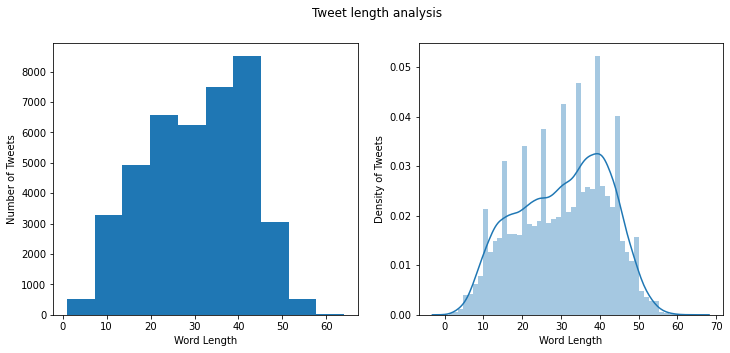

In [11]:
tweet_lengths = df['OriginalTweet'].apply(lambda x: len(x.split()))

plt.subplots(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(tweet_lengths)
plt.suptitle("Tweet length analysis")
plt.xlabel("Word Length")
plt.ylabel("Number of Tweets")

plt.subplot(1,2,2)
sns.distplot(tweet_lengths)
plt.xlabel("Word Length")
plt.ylabel("Density of Tweets")
plt.show()

As we can see, most of the tweets have a lenght between 30 to 50 simple tokens, with very few going over 60.
We also remove tweets with strictly less than 10 tokens and plot some examples of longer tweets.

In [12]:
def get_long_tweets(df, tweet_lengths):
    to_retrun = df.loc[tweet_lengths >= 10]
    return to_retrun

df_lengthy = get_long_tweets(df, tweet_lengths)
print(df_lengthy.shape)
samples = df_lengthy["OriginalTweet"][100:110]

def print_samples(samples):
    for elem in samples:
        print("__________")
        print(elem)
        
print_samples(samples)

(39899, 2)
__________
Rapid delivery food order made (since no slots elsewhere for weeks). All seemed fine until email listing what was out of stock. They are about to deliver...one bottle of orange juice! #coronavirus #panicbuying #whatashitshow
__________
THANK YOU To all the grocery store employees for working so hard making sure everyone is getting what they need.

Please be kind to them itÂs not their fault that we are short on supplies.

#Corona #covid_19 @Â
 https://t.co/QC0uNeVQej
__________
This also needs to be said: going to the grocery store cannot be done completely safely. Meaning, without the risk of getting the #coronavirus or of spreading it. You can reduce risk by staying more than 6 ft from other people &amp; washing your hands, but you can't eliminate it. 1/3
__________
Maybe the coming recession might play in three phases:

(1) Damage on main street by COVID-19 [ongoing]

(2) CB rescue, temp. recovery on credit mkt, but no recovery on consumer econ

(3) Unknown s

We also plot the tweets with length equal to ten to check their contents

In [13]:
for elem in df.loc[tweet_lengths == 10]["OriginalTweet"]:
    print("____")
    print(elem)

____
My thoughts on impacts of coronavirus on food markets

https://t.co/bPodDdPRcE
____
Hi, COVID-19. Thanks for making me do more online shopping.
____
We need more of this to help seniors #CoronavirusOutbreak https://t.co/D09B71I699
____
Thank you @NorthgateGlzMrk for taking care of our abuelos/as! https://t.co/nWmxYoOMHf
____
Most of us will get covid-19 in a supermarket. #letspanic
____
Just online shopping my way through this COVID-19 stuff. https://t.co/7PhJ76sXHJ
____
Supermarket shelves clearing out fast... #Covid_19 #coronavirusnz #CoronavirusPandemic #chch https://t.co/HHg4JQQ4TI
____
NEW: Coronavirus package hits roadblocks amid GOP opposition https://t.co/bCZaS0UTs5 https://t.co/jPa92hvSmI
____
M-C: Political Tribalism Impacts Consumer Sentiment On COVID-19 https://t.co/7nJqhag0fz https://t.co/xtYITOcNFQ
____
Everyone who works at a supermarket right now: #coronavirus https://t.co/IOb3ISs1EF
____
I was a WIC baby. Please choose another brand. https://t.co/SW8e4iPsPk
____
T

We the proceed with the text normalization.
First, we noticed the presence of a undesired UNICODE character that we replace with the character "a". Other than this, we proceed by applying the following transformations:
- Hashtag symbol (#) removal;
- Mention symbol (@) removal;
- URL removal;
- Aphostrophe UNICODE to ASCII casting;
- Special characters removal;
- Numbers removal;
- Formatting symbols removal;
- Escape character removal;
- Extra spaces and spaces before the full stop removal;

In [15]:
# tweet cleaning
# tweets with a low number of tokens should be eliminated

def preprocessing(x):
    
    def remove_hashtags(text): return re.sub(r'#', '' , text)
    def remove_mentions(text): return re.sub(r'@', '' , text)
    def remove_urls(text): return re.sub(r'https?://\S+', ' ', text)
    def change_apostrophe(text): return re.sub(r"Â", "\'", text)
    def remove_special_chars(text): return re.sub(r"[^\w. ',-]", ' ', text)
    def remove_numbers(text): return re.sub(r'[\d]', ' ', text)
    def remove_formatting_symbols(text): return re.sub(r"[\r\n]+",'',text)
    def remove_escape_characters(text): return re.sub(r"\\",'',text)
    def remove_extra_spaces(text): return re.sub(r"\s{2,}",' ',text)
    def remove_space_before_period(text): return re.sub(r"\s\.", ".", text)
    def remove_strange_a(text): return "".join(c if ord(c)!=226 else "a" for c in text )
    x=x.apply(remove_hashtags)
    x=x.apply(remove_mentions)
    x=x.apply(remove_urls)
    x=x.apply(change_apostrophe)
    x=x.apply(remove_special_chars)
    x=x.apply(remove_numbers)
    x=x.apply(remove_formatting_symbols)
    x=x.apply(remove_escape_characters)
    x=x.apply(remove_extra_spaces)
    x=x.apply(remove_space_before_period)
    x=x.str.lower()
    x=x.apply(remove_strange_a)
    return x

In [16]:
# we check the outcome of pre-processing on a small sample
modified_sample = preprocessing(samples)
        
for elem in modified_sample:
    print("___")
    print(elem)

___
rapid delivery food order made since no slots elsewhere for weeks. all seemed fine until email listing what was out of stock. they are about to deliver...one bottle of orange juice coronavirus panicbuying whatashitshow
___
thank you to all the grocery store employees for working so hard making sure everyone is getting what they need. please be kind to them it's not their fault that we are short on supplies. corona covid_ a 
___
this also needs to be said going to the grocery store cannot be done completely safely. meaning, without the risk of getting the coronavirus or of spreading it. you can reduce risk by staying more than ft from other people amp washing your hands, but you can't eliminate it. 
___
maybe the coming recession might play in three phases damage on main street by covid- ongoing cb rescue, temp. recovery on credit mkt, but no recovery on consumer econ unknown second shock later finally brings wall street down altogether spx rut ndx
___
you know it's the end of the w

In [17]:
#%%time
df_lengthy['OriginalTweet']=preprocessing(df_lengthy['OriginalTweet'])
df_lengthy

C:\Users\giova\AppData\Local\Temp\ipykernel_16736\123162112.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lengthy['OriginalTweet']=preprocessing(df_lengthy['OriginalTweet'])


,OriginalTweet,Sentiment
1,advice talk to your neighbours family to excha...,Positive
2,coronavirus australia woolworths to give elder...,Positive
3,my food stock is not the only one which is emp...,Positive
4,"me, ready to go at supermarket during the covi...",Extremely Negative
5,as news of the region's first confirmed covid-...,Positive
...,...,...
41152,airline pilots offering to stock supermarket s...,Neutral
41153,response to complaint not provided citing covi...,Extremely Negative
41154,you know it's getting tough when kameronwilds ...,Positive
41155,is it wrong that the smell of hand sanitizer i...,Neutral


In [18]:
# checking random tweet:
df_lengthy.iloc[32432,0]

'proven fact - notaries cough less than other people. one of my followers has been to a notary on occasions and reported that there was no coughing at all. you are safer with a notary than at the supermarket dmv, or anywhere else during covid coronavirus'

We generate also wordclouds referring to each of the possible label values:

In [19]:
# function to build sentiment wisewordcloud:
def show_wordcloud(df):
    sentiments=df.Sentiment.value_counts().index.to_list()
    
    stopwords = set(STOPWORDS)
    
    plt.subplots(figsize=(14,14))
    i=1
    for senti in sentiments:
        curr=df['OriginalTweet'].loc[df.Sentiment==senti]
        text=curr.values
        text=' '.join(text)
        
        wordcloud=WordCloud(max_words=100, stopwords=stopwords, background_color='white', max_font_size=50).generate(text)
        
        plt.subplot(3,2,i)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.title(senti,fontsize=15)
        i+=1

CPU times: total: 6.42 s
Wall time: 6.89 s


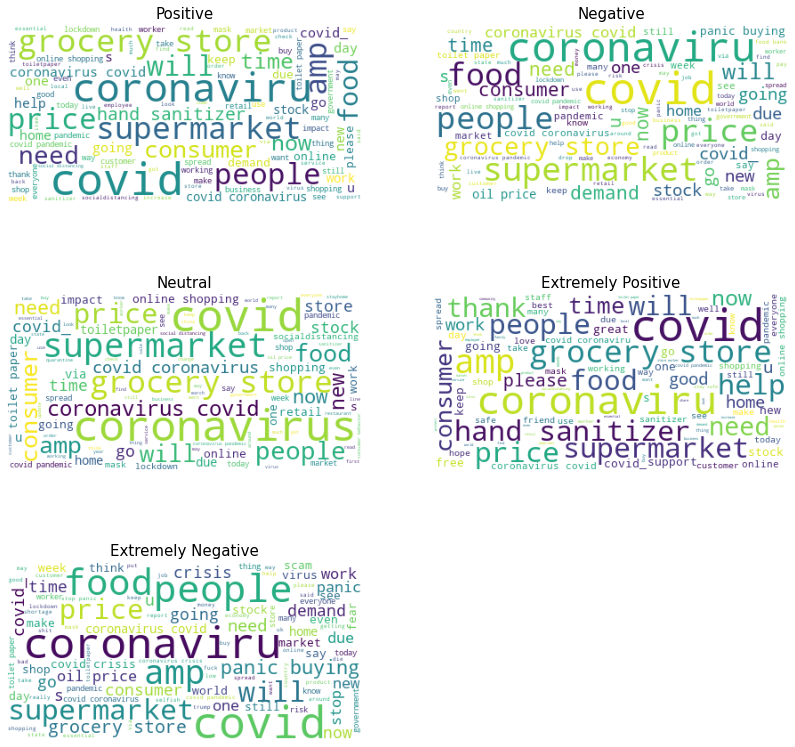

In [20]:
%%time
# generating wordclouds:
show_wordcloud(df_lengthy)

As we can see words of the "coronavirus" or "grocery" semantic fields are predominant in all five wordclouds as they were the main topics discussed during pandemic.
In general there is not much difference in the choice of words between the most used words, but among the smaller ones we can see, for example, that negative posts
are more concerned with "oil price" and "panic buying" and we find other negative words like "scam" or "crisis", while positive posts have a higher presence of "hand sanitizer", "please", "help" or positive words
like "love" and "friend".

We proceed to encode labels with categorical values from 0 (extremely negative) to 4 (extremely positive).
We also plot the label distribution after the removal of short tweets.

In [21]:
# function for label reduction and encoding:
def label_preprocessing(labels):
    lab_dict={
        'Extremely Negative': 0,
        'Negative': 1,
        'Neutral': 2,
        'Positive': 3,
        'Extremely Positive': 4
    }
    labels=labels.map(lab_dict)
    
    return labels

In [22]:
#%%time
# label preprocessing:
df_lengthy['Sentiment']=label_preprocessing(df_lengthy['Sentiment'])
df_lengthy

C:\Users\giova\AppData\Local\Temp\ipykernel_16736\1364274031.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lengthy['Sentiment']=label_preprocessing(df_lengthy['Sentiment'])


,OriginalTweet,Sentiment
1,advice talk to your neighbours family to excha...,3
2,coronavirus australia woolworths to give elder...,3
3,my food stock is not the only one which is emp...,3
4,"me, ready to go at supermarket during the covi...",0
5,as news of the region's first confirmed covid-...,3
...,...,...
41152,airline pilots offering to stock supermarket s...,2
41153,response to complaint not provided citing covi...,0
41154,you know it's getting tough when kameronwilds ...,3
41155,is it wrong that the smell of hand sanitizer i...,2


In [23]:
# checking the new per-class count
senti=df_lengthy['Sentiment'].value_counts()
senti

3    11180
1     9688
2     7011
4     6585
0     5435
Name: Sentiment, dtype: int64

Int64Index([3, 1, 2, 4, 0], dtype='int64')
[11180  9688  7011  6585  5435]


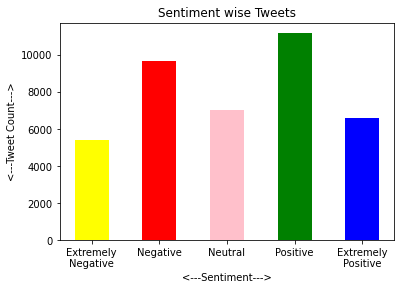

In [24]:
print(senti.index)
print(senti.values)
plt.bar(senti.index, senti.values, color=['green','red','pink', 'blue', 'yellow'], 
        align='center', width=0.5)
plt.xticks(senti.index, ['Positive', 'Negative', 'Neutral', 'Extremely\nPositive', 'Extremely\nNegative',    ])
plt.title('Sentiment wise Tweets')
plt.xlabel('<---Sentiment--->')
plt.ylabel('<---Tweet Count--->')
plt.show()

In [25]:
print(df_lengthy.shape)

(39899, 2)


In [26]:
df_to_use = df_lengthy
df_to_use

,OriginalTweet,Sentiment
1,advice talk to your neighbours family to excha...,3
2,coronavirus australia woolworths to give elder...,3
3,my food stock is not the only one which is emp...,3
4,"me, ready to go at supermarket during the covi...",0
5,as news of the region's first confirmed covid-...,3
...,...,...
41152,airline pilots offering to stock supermarket s...,2
41153,response to complaint not provided citing covi...,0
41154,you know it's getting tough when kameronwilds ...,3
41155,is it wrong that the smell of hand sanitizer i...,2


After cleaning the text, we split the available dataset in Training, Validation and Test sets in a stratified fashion.

First, we split the dataset in 80-20 proportion to obtain the Test set.
Then, we split the previous bigger portion in 80-20 to obtain Training and Validation sets. 

In [28]:
train_split, test_split = train_test_split(df_to_use, test_size = 0.2, random_state = 10, 
                                           stratify =  df_to_use["Sentiment"])
train_split, val_split = train_test_split(train_split, test_size = 0.2, random_state = 10, 
                                           stratify =  train_split["Sentiment"])
print(f"train shape: {train_split.shape}, val shape:{val_split.shape}, test shape:{test_split.shape}")

tweet_list_train = train_split["OriginalTweet"].tolist()
tweet_list_val = val_split["OriginalTweet"].tolist()
tweet_list_test = test_split["OriginalTweet"].tolist()
sentiment_list_train = train_split["Sentiment"].tolist()
sentiment_list_val = val_split["Sentiment"].tolist()
sentiment_list_test = test_split["Sentiment"].tolist()

print(len(sentiment_list_train))
print(len(sentiment_list_val))
print(len(sentiment_list_test))

train shape: (25534, 2), val shape:(6384, 2), test shape:(7980, 2)
25534
6384
7980


Furthermore, we plot, again, the sentiment distribution in all the splits to double-check that they follow the same distribution.

In [29]:
train_senti = train_split["Sentiment"].value_counts()
val_senti = val_split["Sentiment"].value_counts()
test_senti = test_split["Sentiment"].value_counts()

In [30]:
def plot_hist(sent_df):
    print(sent_df)
    plt.bar(sent_df.index, sent_df.values, color=['green','red','pink', 'blue', 'yellow'], 
            align='center', width=0.5)
    plt.xticks(senti.index, ['Positive', 'Negative', 'Neutral', 'Extremely\nPositive', 'Extremely\nNegative',    ])
    plt.title('Sentiment wise Tweets')
    plt.xlabel('<---Sentiment--->')
    plt.ylabel('<---Tweet Count--->')
    plt.show()

3    7155
1    6200
2    4486
4    4214
0    3479
Name: Sentiment, dtype: int64


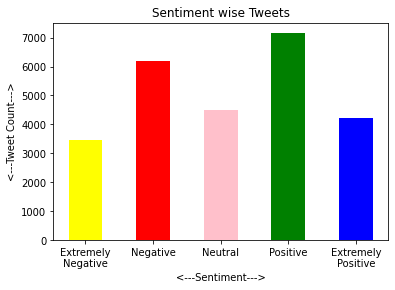

3    1789
1    1550
2    1122
4    1054
0     869
Name: Sentiment, dtype: int64


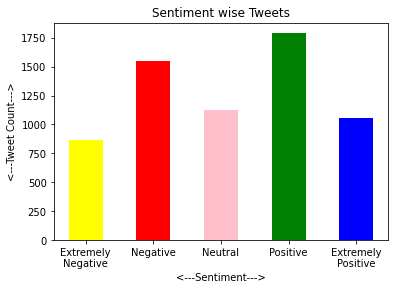

3    2236
1    1938
2    1402
4    1317
0    1087
Name: Sentiment, dtype: int64


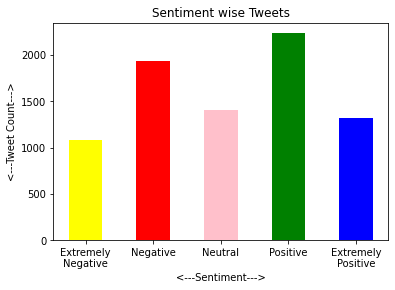

In [31]:
plot_hist(train_senti)
plot_hist(val_senti)
plot_hist(test_senti)

In [32]:
print(np.unique(sentiment_list_train, return_counts = True))
print(np.unique(sentiment_list_val, return_counts = True))
print(np.unique(sentiment_list_test, return_counts = True))

(array([0, 1, 2, 3, 4]), array([3479, 6200, 4486, 7155, 4214], dtype=int64))
(array([0, 1, 2, 3, 4]), array([ 869, 1550, 1122, 1789, 1054], dtype=int64))
(array([0, 1, 2, 3, 4]), array([1087, 1938, 1402, 2236, 1317], dtype=int64))


## Dataset conversion to graph structure

In order to exploit GNN and GCNs we must process the dataset to obtain a graph structure, where each node is associated with a token and linked with other nodes according to its NER relations.
Most of the logic used to build the graph dataset is inside <code>utils.py</code>, so the following cells are used to run the conversion and check its results.


In [ ]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# checking if the drive directory already contains the dataset
print(os.listdir("content/drive/MyDrive/GraphDataset/train/"))

In [33]:
# run this if you wish to generate the dataset from scratch
delete_processed_files("content/processed_train/")
delete_processed_files("content/drive/MyDrive/GraphDataset/train")
delete_processed_files("content/processed_val/")
delete_processed_files("content/drive/MyDrive/GraphDataset/val")
delete_processed_files("content/processed_test/")
delete_processed_files("content/drive/MyDrive/GraphDataset/test")

Now content/processed_train/ is empty
Now content/drive/MyDrive/GraphDataset/train is empty
Now content/processed_val/ is empty
Now content/drive/MyDrive/GraphDataset/val is empty
Now content/processed_test/ is empty
Now content/drive/MyDrive/GraphDataset/test is empty


NB: the conversion process requires time.

In [34]:
# construction of the training dataset
cv19_graph_data_train = Dataset_from_sentences("train", "content/processed_train/", "content/drive/MyDrive/GraphDataset/train/", 
                                               tweet_list_train, sentiment_list_train)
cv19_graph_data_val = Dataset_from_sentences("val", "content/processed_val/", "content/drive/MyDrive/GraphDataset/val/", 
                                               tweet_list_val, sentiment_list_val)
cv19_graph_data_test = Dataset_from_sentences("test", "content/processed_test/", "content/drive/MyDrive/GraphDataset/test/", 
                                              tweet_list_test, sentiment_list_test)

Processing...


['content/processed_train//train.pt']
missing local data in content/processed_train/, downloading...


25534it [1:30:18,  4.71it/s]
Done!
Processing...


['content/processed_val//val.pt']
missing local data in content/processed_val/, downloading...


6384it [18:29,  5.76it/s]
Done!
Processing...


['content/processed_test//test.pt']
missing local data in content/processed_test/, downloading...


7980it [41:04,  3.24it/s]
Done!


In [ ]:
# GLoVe vocabulary serialization
utils.g_utils.serialize_vocab("content/embed/glove_utils_object.pkl")

In [32]:
# GLoVe vocabulary loading
utils.g_utils.load_vocab("content/embed/glove_utils_object.pkl")

In [77]:
# Checking if the dataset has been loaded correctly
print(cv19_graph_data_train)
print(len(cv19_graph_data_train.data_list))
print(len(cv19_graph_data_train))
print(cv19_graph_data_train.num_node_features)
print(cv19_graph_data_train[0]["x"].dtype)
print(cv19_graph_data_train.data_list[1].x)
print(cv19_graph_data_train.data_list[1].y)

Dataset_from_sentences(25534)
25534
25534
50
torch.float64
tensor([[ 0.2716,  0.1121, -0.0924,  ..., -0.0173,  0.1618, -0.0549],
        [ 0.2171,  0.4651, -0.4676,  ..., -0.0438,  0.4101,  0.1796],
        [ 0.4180,  0.2497, -0.4124,  ..., -0.1841, -0.1151, -0.7858],
        ...,
        [ 0.0134,  0.2368, -0.1690,  ..., -0.5666,  0.0447,  0.3039],
        [-0.5641, -0.8358, -0.4029,  ...,  0.2215,  0.4041, -1.2424],
        [ 0.1516,  0.3018, -0.1676,  ..., -0.3565,  0.0164,  0.1022]],
       dtype=torch.float64)
tensor([2])


In [79]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [87]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))


print("Data built from list of sentences:\n " + str(cv19_graph_data_train))

data = cv19_graph_data_train.to(device)
print(data[0].x.get_device())

# apparently, with the "to" method we are modifying the
# elements of the inner list "data_list"; if we access the elements of 
# that list without the ".data_list" notation
# returns tensors that are on the device in the case of the features of the nodes
# while it returns tensors that are on cpu for the attribute "edge_index" and "y"
# this really makes me confused, but using the ".data_list" notation solves the problem
print(data.data_list[0].edge_index.get_device()) 
print(data.data_list[0].y.get_device())
print("________________________________")

loader =  DataLoader(cv19_graph_data_train.data_list, batch_size=10, shuffle=True)
print(f"length of the loader is {len(loader)}")

for batch in loader:
  # each minibatch is again a Data object 
  print("The current batch is the following object:\n " + str(batch))
  print("The number of graphs in the current batch is:\n " + str(batch.num_graphs))
  print("The number of nodes for this batch is: \n" + str(batch.x.shape))
  print(batch.x.device)
  print("The edge indexes for the current batch are:\n " + str(batch.edge_index.shape))
  print(batch.edge_index.device)
  print(batch.edge_index)
  print(batch.edge_index.shape[1] in batch.edge_index)
  print("The ground truth vector is:\n " + str(batch.y))
  print(batch.y.device)

  for i in range(0, batch.num_graphs):
    print("__________AAA__________")
    print(f"elem {i}:")
    print("nodes shape:\n " + str(batch[i].x.shape))
    print("edges idxs for the current sample:\n " + str(batch[i].edge_index))
    print("ground truth shape:\n " + str(batch[i].y.shape))

  # batch is a column vector that maps each node to its respective 
  # graph in the batch, it can be accessed with ".batch" and can 
  # be used to aggregate features of each nodes for each individual graph
  x = scatter(batch.x, batch.batch, dim = 0, reduce = "mean")
 
  print(batch.x.shape) 
  
  print(x.shape)
  break

<IPython.core.display.Javascript object>

Data built from list of sentences:
 Dataset_from_sentences(25534)
0
0
0
________________________________
length of the loader is 2554
The current batch is the following object:
 DataBatch(x=[342, 50], edge_index=[2, 916], y=[10], batch=[342], ptr=[11])
The number of graphs in the current batch is:
 10
The number of nodes for this batch is: 
torch.Size([342, 50])
cuda:0
The edge indexes for the current batch are:
 torch.Size([2, 916])
cuda:0
tensor([[  1,   2,   3,  ..., 340, 340, 341],
        [  0,   3,   1,  ..., 339, 341, 340]], device='cuda:0')
False
The ground truth vector is:
 tensor([1, 3, 3, 4, 1, 2, 2, 2, 1, 1], device='cuda:0')
cuda:0
__________AAA__________
elem 0:
nodes shape:
 torch.Size([45, 50])
edges idxs for the current sample:
 tensor([[ 1,  2,  3,  4,  1,  2,  2,  3,  3,  4,  6,  7,  8,  9,  6,  7,  7,  8,
          8,  9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
         27, 28, 29, 30, 31, 32, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17,
 

Here we plot the node over edges ratio of the train dataset.

In [89]:
total_number_of_edges = cv19_graph_data_train.data_list.edge_index.shape[1]
total_number_of_nodes = cv19_graph_data_train.data_list.x.shape[0]
node_edges_ratio = total_number_of_edges / total_number_of_nodes

print(f'Ratio between nodes and edges: {node_edges_ratio:.2f}')

Ratio between nodes and edges: 2.74
